# Import libraries 

In [67]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
import h5py

# Set seed

In [68]:
key = jax.random.PRNGKey(42)

# Set device type

In [69]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
device = gpu if gpu is not None else cpu
jax.default_device(device)



backend = jax.default_backend()
print(backend)

gpu


# Import training data

In [70]:
# Path to the new HDF5 file
# file_path = "../data/SIM/simulations_10000_100_alpha_beta_mabs_S_noerr.h5"
file_path = "../data/SIM/simulations_50000_1000_mabs_brok_alpha_beta_gamma_sigma_S.h5"

with h5py.File(file_path, "r") as f:
    # Parameters: load directly as (N,) JAX arrays
    params = {key: jnp.array(f[f"params/{key}"][:]) for key in f["params"].keys()}

    # Data columns: load directly as (N, M) JAX arrays
    data = {col: jnp.array(f[f"data/{col}"][:]) for col in f["data"].keys()}


# Number of simulations and SNe per simulation
N = next(iter(params.values())).shape[0]   # N simulations
M = next(iter(data.values())).shape[1]     # M SNe per simulation

print(f"The file contains {N} simulations of size {M}")


The file contains 50000 simulations of size 1000


In [71]:
# Example usage
print("Parameter names:", list(params.keys()))
param_groups = ['mabs', 'beta', 'alpha_low', 'alpha_high', 'x1_ref', 'gamma', 'sigma_int'] # Sort them from easiest to hardest to infer\
# param_groups = ['sigma_int'] # Sort them from easiest to hardest to infer
print(param_groups[0])

Parameter names: ['alpha_high', 'alpha_low', 'beta', 'gamma', 'mabs', 'sigma_int', 'x1_ref']
mabs


In [72]:
print("Column names:", list(data.keys()))

Column names: ['c', 'localcolor', 'magobs', 'mass', 'x1', 'z']


# Compute residuals

In [73]:
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

# Take care to not run the correction twice
mu_planck18, data['magobs']= nntr.rm_cosmo(data['z'], data['magobs'], z_max = 0.2, n_grid=10_000)

# Only update 'mabs' if it exists in params
if 'mabs' in params:
    params['mabs'] = params['mabs'] + 19.3

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


## Apply mask

In [74]:
# Masked version (NaNs)
data_filt = {k: jnp.where(mask, v, jnp.nan) for k, v in data.items()}

# Padded version (zeros)
data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}

## Display residuals

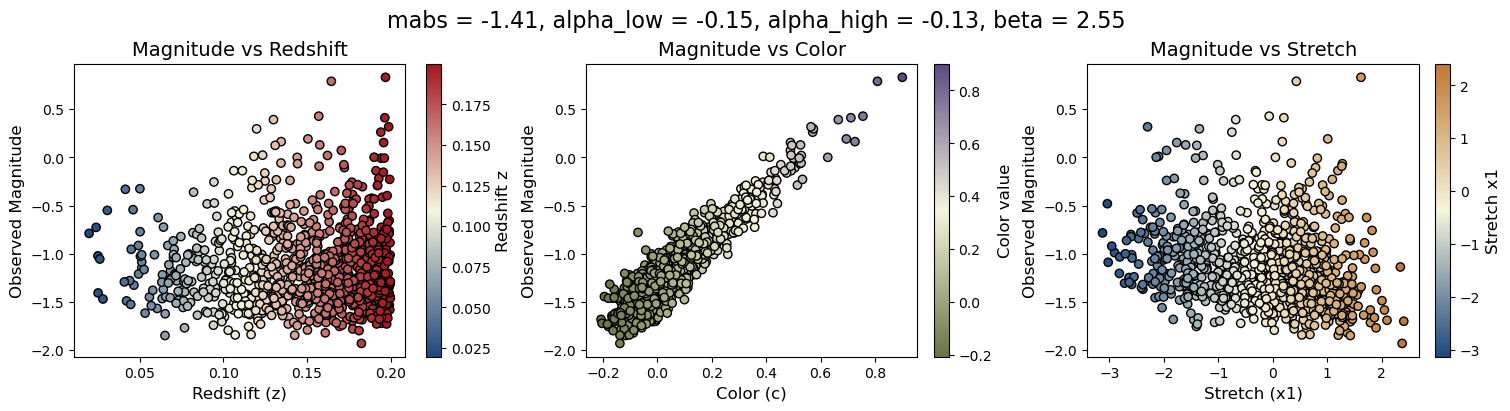

In [75]:
index = 9  # index for your data slice

# Define the color maps
cmap1 = LinearSegmentedColormap.from_list(
    'custom_red_beige_blue',
    ['#1F487E', 'beige', '#A31621']
)

cmap2 = LinearSegmentedColormap.from_list(
    'custom_green_beige_purple',
    ['#687444', 'beige', '#5E4983']
)

cmap3 = LinearSegmentedColormap.from_list(
    'custom_blue_beige_orange',
    ['#1F487E', 'beige', '#C07835']
)

# Create figure and horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# First subplot: z vs magobs
sc1 = axes[0].scatter(
    data_filt['z'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['z'][index, :],
    cmap=cmap1,
    edgecolor='k'
)
axes[0].set_title('Magnitude vs Redshift', fontsize=14)
axes[0].set_xlabel('Redshift (z)', fontsize=12)
axes[0].set_ylabel('Observed Magnitude', fontsize=12)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Redshift z', fontsize=12)

# Second subplot: c vs magobs
sc2 = axes[1].scatter(
    data_filt['c'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['c'][index, :],
    cmap=cmap2,
    edgecolor='k'
)
axes[1].set_title('Magnitude vs Color', fontsize=14)
axes[1].set_xlabel('Color (c)', fontsize=12)
axes[1].set_ylabel('Observed Magnitude', fontsize=12)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Color value', fontsize=12)

# Third subplot: x1 vs magobs
sc3 = axes[2].scatter(
    data_filt['x1'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['x1'][index, :],
    cmap=cmap3,
    edgecolor='k'
)
axes[2].set_title('Magnitude vs Stretch', fontsize=14)
axes[2].set_xlabel('Stretch (x1)', fontsize=12)
axes[2].set_ylabel('Observed Magnitude', fontsize=12)
cbar3 = plt.colorbar(sc3, ax=axes[2])
cbar3.set_label('Stretch x1', fontsize=12)

fig.suptitle(
    (
        f"mabs = {params['mabs'][index]:.2f}, "
        f"alpha_low = {params['alpha_low'][index]:.2f}, alpha_high = {params['alpha_high'][index]:.2f}, "
        f"beta = {params['beta'][index]:.2f}"
    ),
    fontsize=16
)

plt.show()



In [76]:
# select_columns = ['magobs','c', 'x1'] #,'x1'
# data = {k: v for k, v in data.items() if k in select_columns}
# data_filt = {k: v for k, v in data_filt.items() if k in select_columns}
# data_padded = {k: v for k, v in data_padded.items() if k in select_columns}

# select_columns = ['magobs', 'magobs_err', 'c', 'c_err', 'x1','x1_err', 'mass', 'mass_err', 'localcolor', 'localcolor_err']
select_columns = ['magobs', 'c', 'x1', 'mass', 'localcolor']
select_params  = list(params.keys())  # or subset you want

# Suppose data is a dictionary of arrays, each shape (N, M)
# Stack over all objects for each feature to compute statistics
data_stats = {}
for col in select_columns:
    # flatten over all objects in all examples
    all_values = jnp.concatenate([data[col].ravel() for data in [data]])  # replace with training set list if needed
    mu = jnp.mean(all_values)
    sigma = jnp.std(all_values) + 1e-8
    data_stats[col] = {'mu': mu, 'sigma': sigma}

param_stats = {}
for dic_key in select_params:
    all_values = jnp.concatenate([params[dic_key].ravel() for params in [params]])  # replace with training set list
    mu = jnp.mean(all_values)
    sigma = jnp.std(all_values) + 1e-8
    param_stats[dic_key] = {'mu': mu, 'sigma': sigma}

def normalize(data_dict, stats_dict):
    normed = {}
    for k, v in data_dict.items():
        if k in stats_dict:
            mu = stats_dict[k]['mu']
            sigma = stats_dict[k]['sigma']
            normed[k] = (v - mu) / sigma
        else:
            normed[k] = v  # leave untouched
    return normed
    
def unnormalize(normed_params, param_stats):
    unnormed = {}
    for k, v in normed_params.items():
        if k in param_stats:
            mu = param_stats[k]['mu']
            sigma = param_stats[k]['sigma']
            unnormed[k] = v * sigma + mu  # inverse of normalization
        else:
            unnormed[k] = v  # leave untouched
    return unnormed

bounds_phys = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

data   = normalize(data, data_stats)
params = normalize(params, param_stats)

data_padded_normed = {}
for col in select_columns:
    x = data_padded[col]
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']
    x_norm = (x - mu) / sigma
    x_norm = jnp.where(mask, x_norm, 0.0)
    data_padded_normed[col] = x_norm

data_padded = data_padded_normed

# Prepare train and test sets

## Set bounds

In [77]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

## Label data

In [78]:
# -----------------------------------------
# Autoregressive dataset construction
# -----------------------------------------

param_names = list(params.keys())
K = len(param_names)  # total number of parameters

# Convert bounds
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

# LHS false parameters
key, lhs_key = jax.random.split(key)
lhs_samples = nntr.lhs_jax(lhs_key, K, N)
false_params = mins + (maxs - mins) * lhs_samples   # (N,K)

# True params in array form
param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)

# ----- Observational data concatenation (unchanged) -----

data_names = list(data_padded.keys())
n_cols = len(data_names)

data_arrays = [data_padded[name] for name in data_names]
data_stacked = jnp.stack(data_arrays, axis=-1)  # (N, M, n_cols)
data_concat  = data_stacked.reshape(N, M * n_cols)

## Prepare train/test sets

In [79]:
# ----------------------------------------------------
# Global train / test split (shared across all groups)
# ----------------------------------------------------

key, split_key = jax.random.split(key)

indices = jnp.arange(N)
perm = jax.random.permutation(split_key, indices)

n_test = int(0.3 * N)
test_idx  = perm[:n_test]
train_idx = perm[n_test:]

# Slice once
data_train  = data_concat[train_idx]
data_test   = data_concat[test_idx]

param_true_train  = param_true[train_idx]
param_true_test   = param_true[test_idx]

false_params_train = false_params[train_idx]
false_params_test  = false_params[test_idx]

mask_train = mask[train_idx]
mask_test  = mask[test_idx]


## Concatenate data

In [80]:
# ----------------------------------------------------
# Build one dataset per parameter group
# ----------------------------------------------------

all_group_datasets = []

for g, group in enumerate(param_groups):

    # Parameter indices
    group_list = [group] if isinstance(group, str) else group
    group_idx = jnp.array([param_names.index(name) for name in group_list])

    prev_groups = [
        p for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    prev_idx = (
        jnp.array([param_names.index(name) for name in prev_groups], dtype=int)
        if len(prev_groups) > 0 else jnp.array([], dtype=int)
    )

    # ---------------------------------
    # Labels (same RNG logic preserved)
    # ---------------------------------
    key, label_key = jax.random.split(key)

    labels_train = jax.random.uniform(label_key, (train_idx.shape[0],)) > 0.5
    labels_test  = jax.random.uniform(label_key, (test_idx.shape[0],)) > 0.5

    # ---------------------------------
    # Build params for TRAIN
    # ---------------------------------
    params_train = jnp.array(param_true_train)
    chosen_train = jnp.where(
        labels_train[:, None],
        param_true_train[:, group_idx],
        false_params_train[:, group_idx],
    )
    params_train = params_train.at[:, group_idx].set(chosen_train)

    # ---------------------------------
    # Build params for TEST
    # ---------------------------------
    params_test = jnp.array(param_true_test)
    chosen_test = jnp.where(
        labels_test[:, None],
        param_true_test[:, group_idx],
        false_params_test[:, group_idx],
    )
    params_test = params_test.at[:, group_idx].set(chosen_test)

    # Visible parameters
    visible_idx = (
        jnp.concatenate([prev_idx, group_idx], axis=0)
        if prev_idx.size > 0 else group_idx
    )

    params_visible_train = params_train[:, visible_idx]
    params_visible_test  = params_test[:, visible_idx]

    # Inputs / outputs
    inputs_train = jnp.concatenate(
        [data_train, mask_train, params_visible_train], axis=-1
    )
    inputs_test = jnp.concatenate(
        [data_test, mask_test, params_visible_test], axis=-1
    )

    outputs_train = labels_train.astype(jnp.int32)[:, None]
    outputs_test  = labels_test.astype(jnp.int32)[:, None]

    all_group_datasets.append(
        (inputs_train, outputs_train, inputs_test, outputs_test)
    )


# Build a neural network

In [81]:
class Phi(nnx.Module):
    def __init__(self, Nsize, n_cols, n_params, *, rngs):
        self.linear1 = nnx.Linear(n_cols + n_params, 2*Nsize, rngs=rngs)
        self.ln1     = nnx.LayerNorm(2*Nsize, rngs=rngs)
        self.linear2 = nnx.Linear(2*Nsize, 2*Nsize, rngs=rngs)
        self.ln2     = nnx.LayerNorm(2*Nsize, rngs=rngs)
        self.linear5 = nnx.Linear(2*Nsize, Nsize, rngs=rngs)
        # self.ln5     = nnx.LayerNorm(Nsize, rngs=rngs)

    def __call__(self, data, params):
        h = jnp.concatenate([data, params], axis=-1)

        h = self.linear1(h)
        # h = self.ln1(h)
        h = nnx.leaky_relu(h)

        h = self.linear2(h)
        # h = self.ln2(h)
        h = nnx.leaky_relu(h)

        h = self.linear5(h)
        # h = self.ln5(h)

        return h



class Rho(nnx.Module):
    """
    Neural network module for the Rho network in a Deep Set architecture
    with separate LayerNorm for pooled features and theta.
    """
    def __init__(self, Nsize_p, Nsize_r, N_size_params, *, rngs):
        self.linear1 = nnx.Linear(Nsize_p + N_size_params, Nsize_r, rngs=rngs)
        self.ln1     = nnx.LayerNorm(Nsize_r, rngs=rngs)
        self.linear2 = nnx.Linear(Nsize_r, Nsize_r, rngs=rngs)
        self.ln2     = nnx.LayerNorm(Nsize_r, rngs=rngs)
        # self.linear3 = nnx.Linear(Nsize_r, Nsize_r, rngs=rngs)
        # self.ln3     = nnx.LayerNorm(Nsize_r, rngs=rngs)
        self.linear5 = nnx.Linear(Nsize_r, 1, rngs=rngs)

    def __call__(self, dropout, pooled_features, params):
        # Concatenate pooled features and embedding
        x = jnp.concatenate([pooled_features, params], axis=-1)

        x = self.linear1(x)
        # x = self.ln1(x)
        x = nnx.leaky_relu(x)
        x = dropout(x)

        x = self.linear2(x)
        # x = self.ln2(x)
        x = nnx.leaky_relu(x)
        x = dropout(x)

        # x = self.linear3(x)
        # # x = self.ln3(x)
        # x = nnx.leaky_relu(x)
        # x = dropout(x)

        return self.linear5(x)


class DeepSetClassifier(nnx.Module):
    """
    Deep Set Classifier model combining Phi and Rho networks.
    """
    def __init__(self, dropout_rate, Nsize_p, Nsize_r,
                 n_cols, n_params, *, rngs):

        self.dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        self.n_cols   = n_cols
        self.n_params = n_params

        self.phi = Phi(Nsize_p, n_cols, n_params, rngs=rngs)
        self.rho = Rho(Nsize_p, Nsize_r, n_params, rngs=rngs)

    def __call__(self, input_data):
        # ----------------------------------------------------
        # Accept both shape (N, D) and (D,) without failing
        # ----------------------------------------------------
        if input_data.ndim == 1:
            input_data = input_data[None, :]

        N = input_data.shape[0]
        input_dim = input_data.shape[1]

        # Compute M first from input size
        # Total input columns = M*n_cols + n_params + M (mask)
        M = (input_dim - self.n_params) // (self.n_cols + 1)

        # Reshape data columns
        data = input_data[:, :M*self.n_cols].reshape(N, M, self.n_cols)

        # Slice mask (last M columns)
        mask = input_data[:, -M-self.n_params:-self.n_params]         # shape (N, M)

        # Parameters
        theta = input_data[:, -self.n_params:]  # shape (N, n_params)

        theta_fill = jnp.broadcast_to(theta[:, None, :], (N, M, self.n_params))

        # Apply Phi
        h = self.phi(data, theta_fill)

        # Apply mask
        h_masked = h * mask[..., None]

        # Pool (masked average)
        mask_sum = jnp.sum(mask, axis=1, keepdims=True)
        mask_sum = jnp.where(mask_sum == 0, 1.0, mask_sum)
        pooled = jnp.sum(h_masked, axis=1) / mask_sum

        # pooled_N = jnp.concatenate([pooled, mask_sum], axis=-1)

        # Apply Rho
        return self.rho(self.dropout, pooled, theta)

In [82]:
# Define the size of the different network layers
Nsize_p = 64 #128 
Nsize_r = 512 #256 

n_cols = len(data_names)
print('# of columns :', n_cols)
n_params = len(param_names)
print('# of params :', n_params)


# of columns : 5
# of params : 7


In [93]:
# ----------------------------
# Prepare a list of models, one per group
# ----------------------------

models_per_group = []
group_configs = []
rng = nnx.Rngs(0)

for g, group in enumerate(param_groups):
    # Determine number of parameters visible for this group
    prev_groups = [
        p
        for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    group_list = [group] if isinstance(group, str) else group
    visible_param_names = prev_groups + group_list
    n_params_visible = len(visible_param_names)

    print(
        f"Group {g}: visible parameters = {visible_param_names}, "
        f"total = {n_params_visible}"
    )

    # Create DeepSetClassifier for this group
    model_g = DeepSetClassifier(
        dropout_rate=0.1,
        Nsize_p=Nsize_p,
        Nsize_r=Nsize_r,
        n_cols=n_cols,
        n_params=n_params_visible,
        rngs=rng,
    )

    models_per_group.append(model_g)

    # ---- CONFIG CAPTURE ----
    group_configs.append({
        "group_id": g,
        "n_params_visible": n_params_visible,
        "visible_param_names": visible_param_names,
    })


model_config = {
    "shared": {
        "Nsize_p": Nsize_p,
        "Nsize_r": Nsize_r,
        "n_cols": n_cols,
    },
    "groups": group_configs,
}

# Optional: visualize one model
nnx.display(models_per_group[0])


Group 0: visible parameters = ['mabs'], total = 1
Group 1: visible parameters = ['mabs', 'beta'], total = 2
Group 2: visible parameters = ['mabs', 'beta', 'alpha_low'], total = 3
Group 3: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high'], total = 4
Group 4: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high', 'x1_ref'], total = 5
Group 5: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high', 'x1_ref', 'gamma'], total = 6
Group 6: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high', 'x1_ref', 'gamma', 'sigma_int'], total = 7


In [94]:
# Define the learning rate schedule 
learning_rate_schedule = optax.exponential_decay(
    init_value=5e-3,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

# Train NN

=== Training model for group 6: sigma_int ===


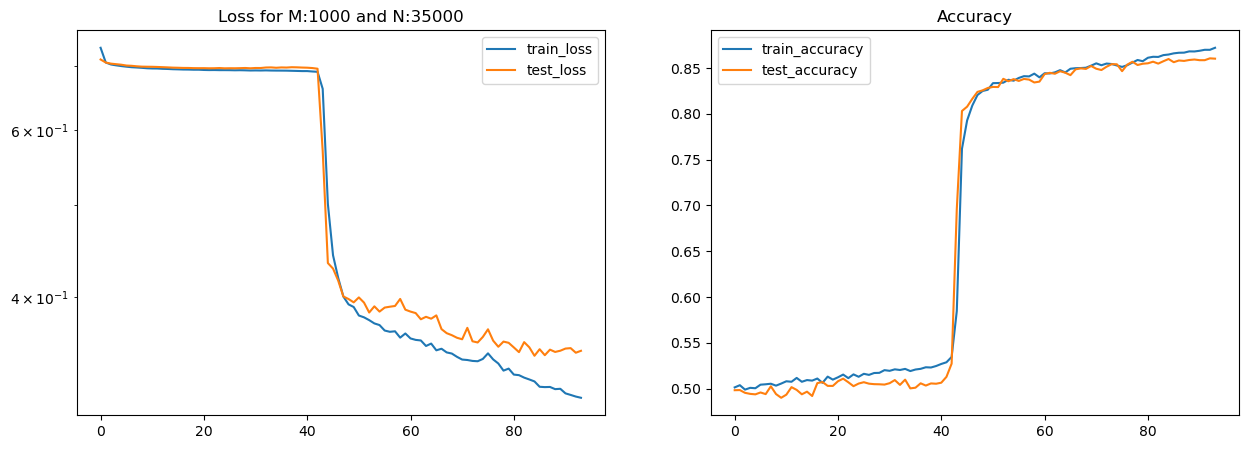


 Early stopping at epoch 95 (accuracy >= 0.7 and 10 strikes) 



In [95]:
# Early stopping parameters
n_batch = 100
patience = 20 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs
# all_group_datasets is a list of (inputs_g, outputs_g)
metrics_histories = []

for g, (train_data, train_labels, test_data, test_labels) in enumerate(all_group_datasets):

    print(f"\n=== Training model for group {g}: {param_groups[g]} ===")

    train_data  = jax.device_put(train_data, cpu)
    train_labels = jax.device_put(train_labels, cpu)
    test_data   = jax.device_put(test_data, cpu)
    test_labels  = jax.device_put(test_labels, cpu)

    optimizer = nnx.Optimizer(
        models_per_group[g],
        optax.adamw(learning_rate_schedule, momentum)
    )

    batch_size = train_data.shape[0] // n_batch

    model_g, metrics_history, key = nntr.train_loop(
        model=models_per_group[g],
        optimizer=optimizer,
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        key=key,
        epochs=epochs,
        batch_size=batch_size,
        patience=patience,
        metrics_history={'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []},
        M=M,
        N=int(N*0.7),
        cpu=cpu,
        gpu=gpu,
        group_id=g,
        group_params=param_groups[g],
        plot_flag=True
    )

    models_per_group[g] = model_g
    metrics_histories.append(metrics_history)


# Test NN

## Test Accuracy

In [96]:
# Set models to evaluation mode
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

batch_size = 128

# Initialize storage for metrics per group
metrics_per_group = []

# Loop over groups (autoregressive)
for g, model_g in enumerate(models_per_group):

    # Unpack GROUP-SPECIFIC train/test sets (shared split, different labels/inputs)
    _, _, inputs_test, labels_test = all_group_datasets[g]

    num_samples = inputs_test.shape[0]

    all_logits = []
    all_labels = []

    for i in range(0, num_samples, batch_size):
        xb = inputs_test[i : i + batch_size]
        yb = labels_test[i : i + batch_size]

        # logits from model
        logits = nntr.pred_step(model_g, xb)
        all_logits.append(logits)
        all_labels.append(yb > 0.5)

    # Merge batches
    all_logits = jnp.concatenate(all_logits, axis=0)
    all_preds  = jsp.special.expit(all_logits) > 0.5
    all_labels = jnp.concatenate(all_labels, axis=0)

    # Confusion matrix components
    TP = jnp.sum((all_preds == 1) & (all_labels == 1))
    TN = jnp.sum((all_preds == 0) & (all_labels == 0))
    FP = jnp.sum((all_preds == 1) & (all_labels == 0))
    FN = jnp.sum((all_preds == 0) & (all_labels == 1))

    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    precision   = TP / (TP + FP + 1e-8)
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    print(
        f"Group {g} ({param_groups[g]}): "
        f"Accuracy={accuracy:.3f}, "
        f"Precision={precision:.3f}, "
        f"Sensitivity={sensitivity:.3f}, "
        f"Specificity={specificity:.3f}"
    )

    metrics_per_group.append({
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
    })


Group 0 (mabs): Accuracy=0.899, Precision=0.849, Sensitivity=0.970, Specificity=0.827
Group 1 (beta): Accuracy=0.864, Precision=0.817, Sensitivity=0.936, Specificity=0.792
Group 2 (alpha_low): Accuracy=0.859, Precision=0.795, Sensitivity=0.965, Specificity=0.754
Group 3 (alpha_high): Accuracy=0.867, Precision=0.817, Sensitivity=0.943, Specificity=0.792
Group 4 (x1_ref): Accuracy=0.907, Precision=0.872, Sensitivity=0.955, Specificity=0.858
Group 5 (gamma): Accuracy=0.832, Precision=0.771, Sensitivity=0.952, Specificity=0.708
Group 6 (sigma_int): Accuracy=0.858, Precision=0.808, Sensitivity=0.937, Specificity=0.781


## Test TARP

In [97]:
# ----------------------------
# Set all models to evaluation mode
# ----------------------------
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

# ----------------------------
# Parameter info
# ----------------------------
param_names = list(bounds.keys())
N_SIM_PARAMS = len(param_names)

# ----------------------------
# Select "true" parameter samples from the LAST group (TEST SET ONLY)
# ----------------------------
_, _, inputs_test_last, outputs_test_last = all_group_datasets[-1]

mask_true = outputs_test_last[:, 0] == 1  # label == 1
N_sims = int(jnp.minimum(100, jnp.sum(mask_true)))
true_idx = jnp.nonzero(mask_true, size=N_sims, fill_value=0)[0]

# ----------------------------
# Flatten param_groups into a unique ordered list
# ----------------------------
global_param_names = []
for group in param_groups:
    group_list = [group] if isinstance(group, str) else group
    for p in group_list:
        if p not in global_param_names:
            global_param_names.append(p)

NDIM = len(global_param_names)

# ----------------------------
# Parameter bounds (global ordering)
# ----------------------------
BOUNDS = jnp.array([
    [bounds[p]['min'], bounds[p]['max']]
    for p in global_param_names
])

# ----------------------------
# Extract test inputs and full theta for MCMC / TARP
# ----------------------------
xy_test = inputs_test_last[true_idx, :-NDIM][:N_sims, :]
theta_star = inputs_test_last[true_idx, -NDIM:][:N_sims, :]


In [98]:
alpha_grid = jnp.linspace(0, 1, 50)

if backend == "METAL":
    # METAL GPU branch
    print("Launching MCMC (JIT‐compiled) on METAL GPU... (this may take time)")
    with jax.default_device(cpu):
        ecp_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_with_progress_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, global_param_names, batch_size=20
        )   
    print("MCMC finished on METAL")

elif backend in ("cuda", "gpu"):
    # CUDA GPU branch
    print("Launching MCMC (JIT‐compiled) on CUDA GPU... (this may take time)")
    with jax.default_device(cpu):
        ecp_vals, f_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, global_param_names
        )   
    print("MCMC finished on CUDA")

else:
    # CPU fallback
    print("Launching MCMC (JIT‐compiled) on CPU... (this may take time)")
    with jax.default_device(cpu):
        ecp_vals, f_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, global_param_names
        )
    print("MCMC finished on CPU")

Launching MCMC (JIT‐compiled) on CUDA GPU... (this may take time)
MCMC finished on CUDA


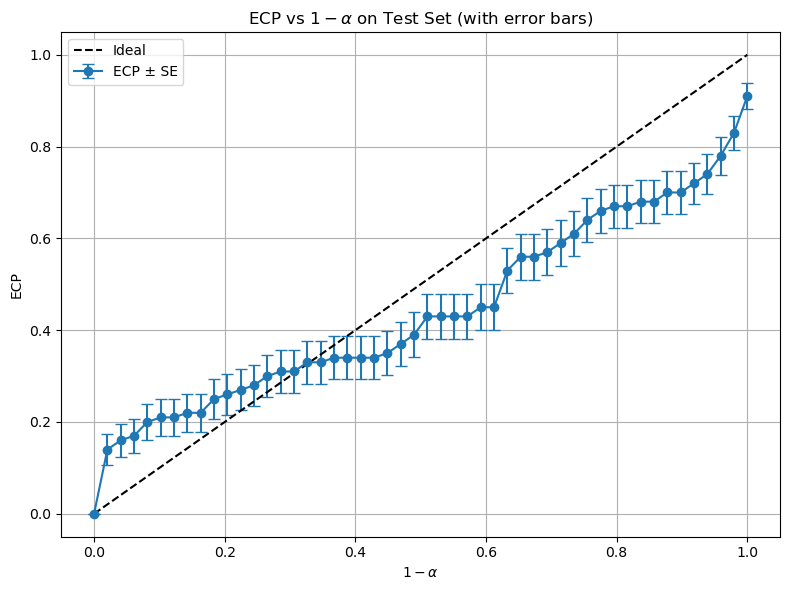

In [99]:
# Example: 1 - alpha grid and computed ecp
alpha_grid = jnp.array(alpha_grid)
ecp = jnp.array(ecp_vals)

# Compute standard error for binomial proportion
se = jnp.sqrt(ecp * (1 - ecp) / N_sims) #https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wald_interval

# CHECK HOW TO COMPUTE THE ERROR

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(1 - alpha_grid, ecp, yerr=se, fmt='o-', capsize=4, label='ECP ± SE')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (with error bars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test posterior

In [105]:
index = 10

# Convert theta_star to dict for unnormalisation
theta_star_dict = {name: theta_star[index, i] for i, name in enumerate(global_param_names)}

# Unnormalize
theta_star_unnormed_dict = unnormalize(theta_star_dict, param_stats)

# Convert back to array in the same order as global_param_names
theta_star_unnormed = jnp.array([theta_star_unnormed_dict[name] for name in global_param_names])

print(param_groups)
print(theta_star_unnormed)

['mabs', 'beta', 'alpha_low', 'alpha_high', 'x1_ref', 'gamma', 'sigma_int']
[-1.2902297   3.8520005  -0.4067196  -0.19682032 -0.07605506  0.01606499
  0.23299082]


In [106]:
# Select a single test sample (or batch) as input
test_data = xy_test[index, :]  # single sample, shape (n_features,)

with jax.default_device(cpu):
    def log_post(theta):
        # Use the new grouped log-prob function
        return nnte.log_prob_fn_groups(
            theta,
            models_per_group,  # list of models per group
            test_data,
            BOUNDS,
            param_groups,
            global_param_names
        )

    # Initial position at the middle of priors
    theta_init = theta_star[index,:] #(BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0

    print("Launch MCMC ...")
    # Run MCMC
    key, post = nnte.sample_posterior(
        log_post,
        n_warmup=200,
        n_samples=200,
        init_position=theta_init,
        rng_key=key
    )

print("...finished")


Launch MCMC ...
...finished


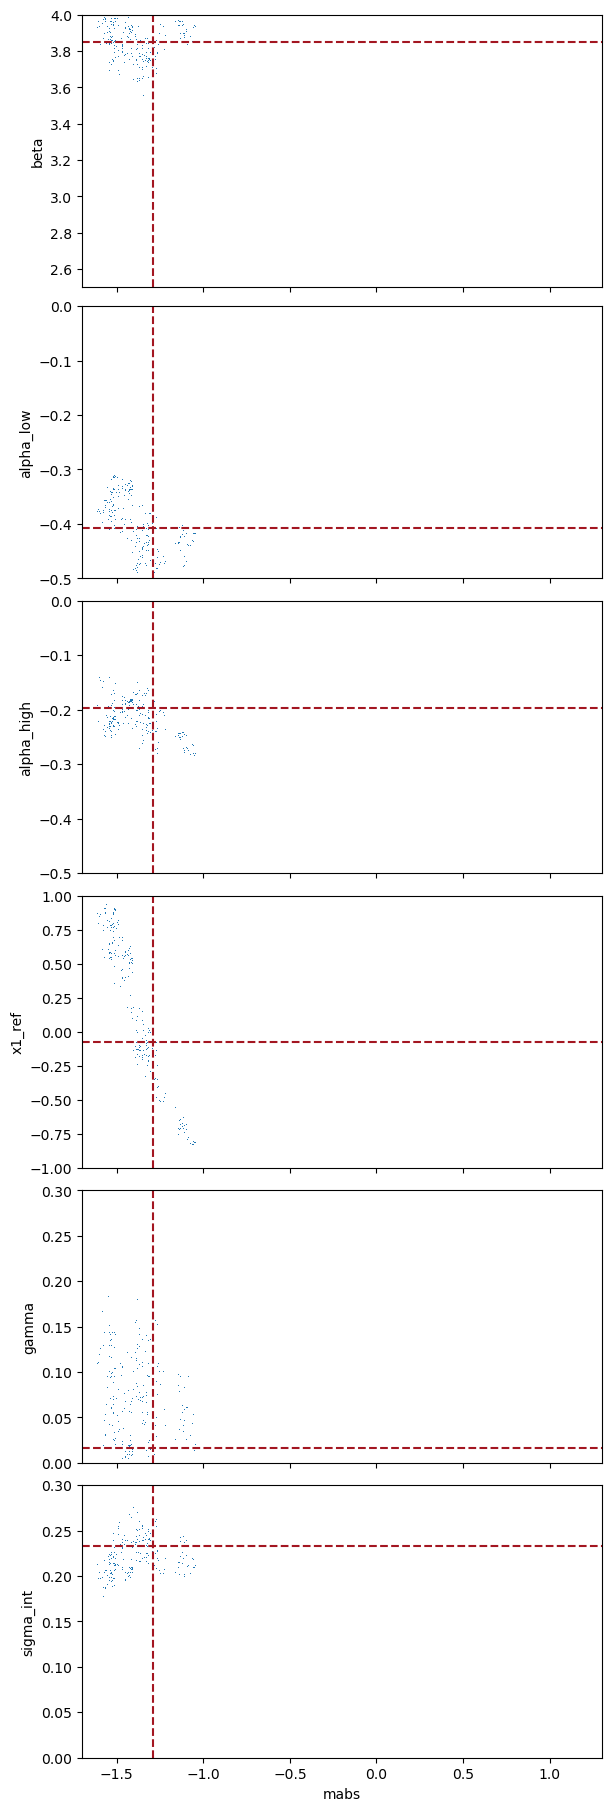

In [107]:
# post has shape (n_samples, n_params)
n_samples, n_params = post.shape

BOUNDS_phys = jnp.array([
    [bounds_phys[p]['min'], bounds_phys[p]['max']]
    for p in global_param_names
])

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]


# Create one subplot per remaining parameter
fig, axes = plt.subplots(
    n_params - 1,
    1,
    figsize=(6, 3 * (n_params - 1)),
    sharex=True,
    constrained_layout=True
)

# Ensure axes is iterable even if n_params == 2
if n_params == 2:
    axes = [axes]

for i, ax in enumerate(axes, start=1):
    y = post_unnormed[:, i]

    ax.plot(
        x,
        y,
        'o',
        markersize=4
    )

    # Axis limits from priors
    ax.set_xlim(BOUNDS_phys[0, 0], BOUNDS_phys[0, 1])
    ax.set_ylim(BOUNDS_phys[i, 0], BOUNDS_phys[i, 1])

    # Labels
    ax.set_ylabel(global_param_names[i])

    # --- Add cross for the true value ---
    true_x = theta_star_unnormed[0]   # true value of x
    true_y = theta_star_unnormed[i]   # true value of y
    ax.axvline(true_x, color="#A31621", linestyle='--', lw=1.5)   # vertical line
    ax.axhline(true_y, color="#A31621", linestyle='--', lw=1.5)   # horizontal line

axes[-1].set_xlabel(global_param_names[0])

plt.show()


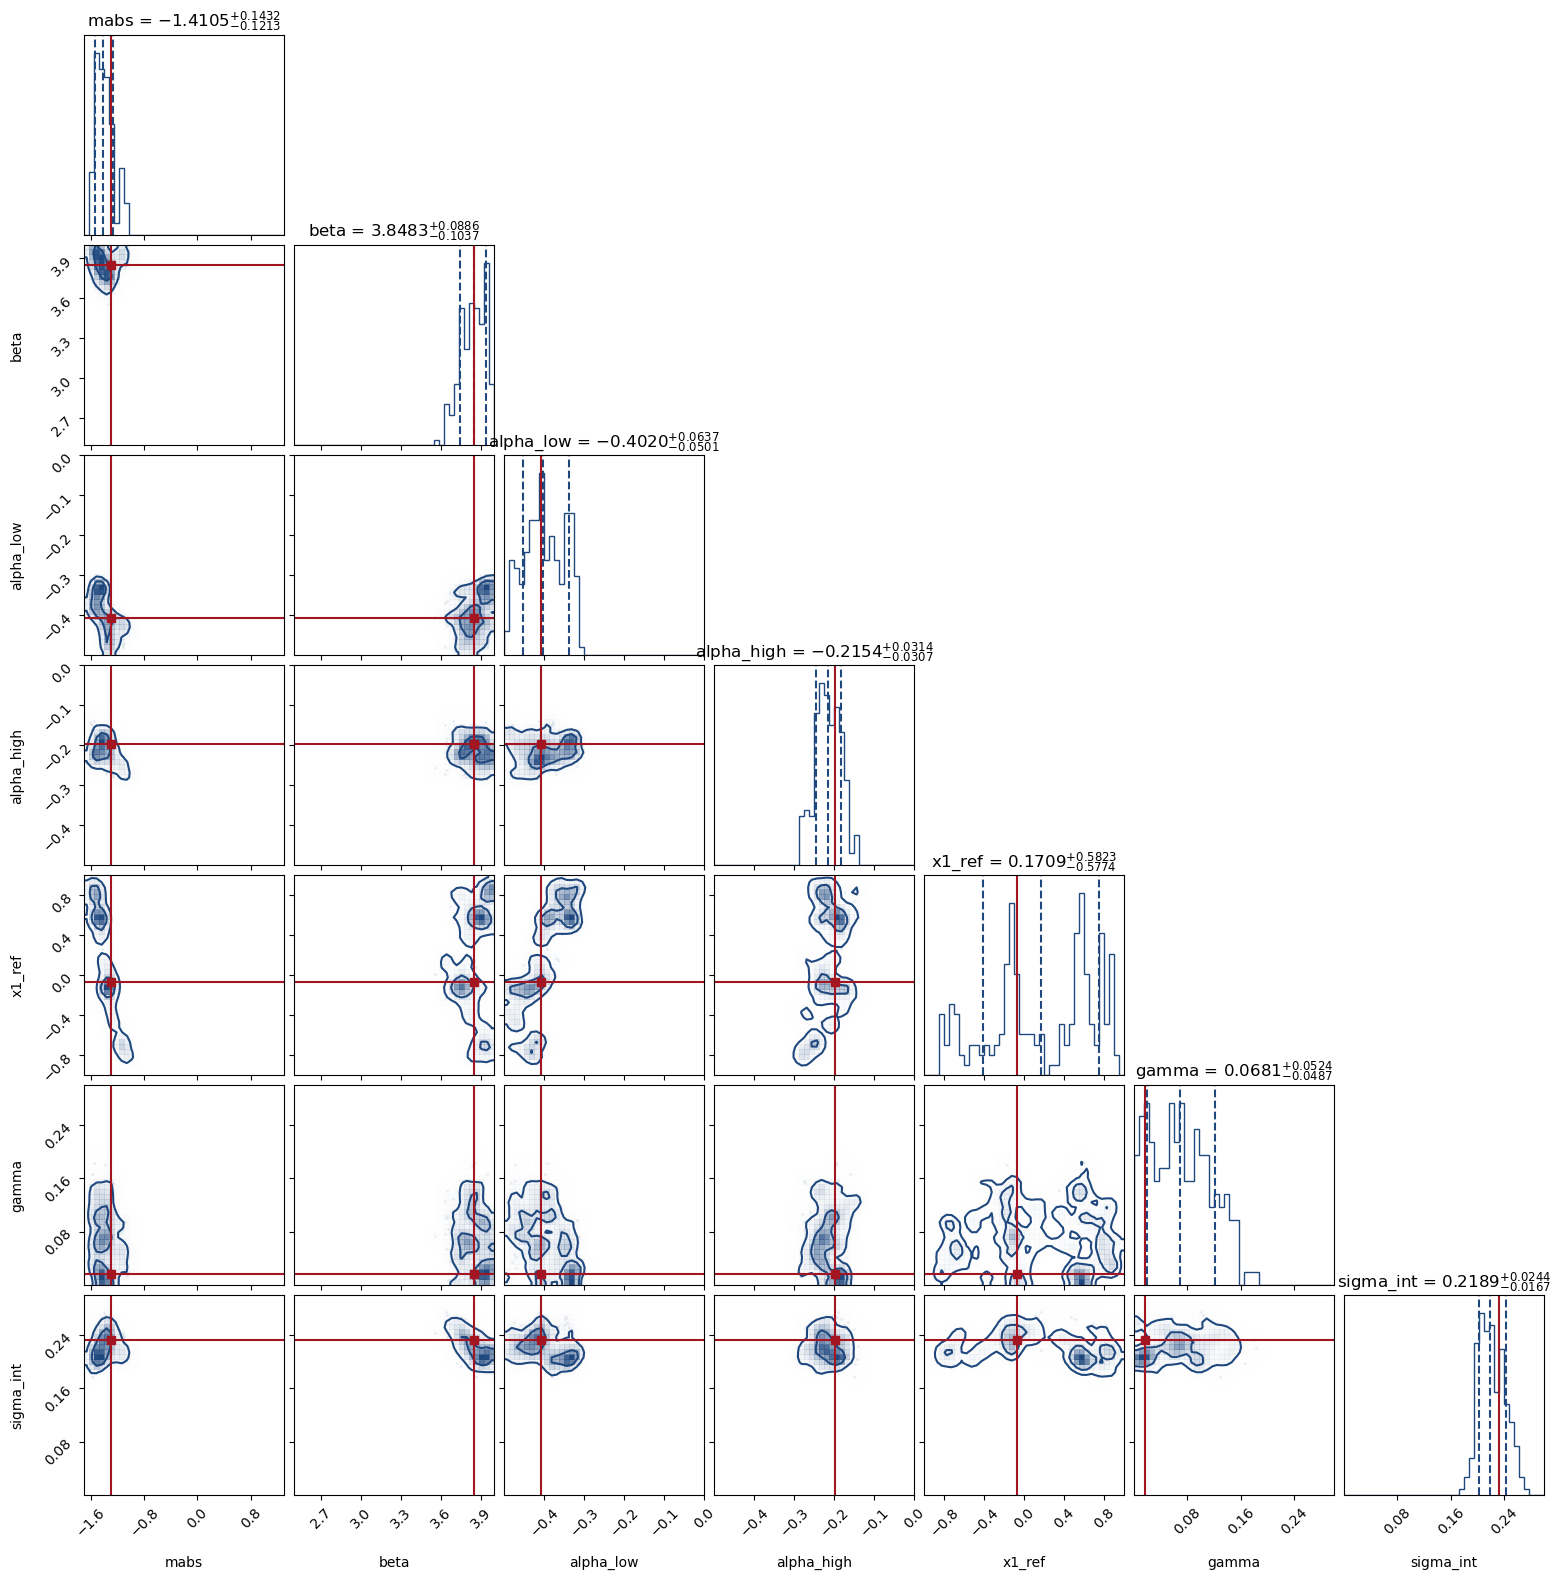

In [108]:
import corner
import numpy as np


fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=[tuple(b) for b in BOUNDS_phys],
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truths=theta_star_unnormed[:],
    truth_color="#A31621", 
    truth_alpha=0.8
)


plt.show()

# Save NN to disk

In [104]:
# Save the trained model for future use
save_path = '../data/NNs/nn_model'
nntr.save_autoregressive_nn(models_per_group,save_path, model_config)
print('NNs saved to ' + save_path)

NNs saved to ../data/NNs/nn_model
